In [409]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [410]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from string import punctuation
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

[nltk_data] Downloading package punkt_tab to /home/cuong/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cuong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cuong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [411]:
data = pd.read_csv('data/scopusabstracts.csv', delimiter='#')
data['TEXT'] = data['TITLE'] + ' ' + data['ABSTRACT']
data

,ID,TITLE,ABSTRACT,TEXT
0,id1,Anomaly detection in wide area imagery [Geniş ...,This study is about detecting anomalies in wid...,Anomaly detection in wide area imagery [Geniş ...
1,id2,Person re-identification with deep kronecker-p...,Person re-identification (re-ID) aims to robus...,Person re-identification with deep kronecker-p...
2,id3,Crack detection in images of masonry using cnns,While there is a significant body of research ...,Crack detection in images of masonry using cnn...
3,id4,Towards an energy efficient code generator for...,Using a smartphone become the part of our ever...,Towards an energy efficient code generator for...
4,id5,Sub-polyhedral scheduling using (Unit-)two-var...,Polyhedral compilation has been successful in ...,Sub-polyhedral scheduling using (Unit-)two-var...
...,...,...,...,...
1138,id1328,Colorimetric point-of-care paper-based sensors...,Creatinine is a clinically significant analyte...,Colorimetric point-of-care paper-based sensors...
1139,id1329,Calcium identification and scoring based on ec...,"Currently, an echocardiography expert is neede...",Calcium identification and scoring based on ec...
1140,id1330,Considering filter importance and irreplaceabi...,Deep convolutional neural network (CNNs) have ...,Considering filter importance and irreplaceabi...
1141,id1331,Low-complexity bit-serial sequential polynomia...,GF(2m) multiplication is a complex and perform...,Low-complexity bit-serial sequential polynomia...


In [412]:
# Sets of punctuation and stopwords
PUNCTUATIONS = set(punctuation)
STOPSWORDS = set(stopwords.words('english'))
STOPSWORDS.update(['...'])

def print_tokens(tokens_list: list[list[str]]) -> None:
    for idx, tokens in enumerate(tokens_list):
        token_str = ' '.join(tokens)
        print(f'{idx}:\n{token_str}')
        print('-----------------------------------')
        print()

def lower_case(tokens_list: list[list[str]]) -> list[list[str]]:
    return [[token.lower() for token in tokens_i] for tokens_i in tokens_list]

def remove_punctuation(tokens_list: list[list[str]]) -> list[list[str]]:
    return [[token for token in tokens_i if token not in PUNCTUATIONS] for tokens_i in tokens_list]

def remove_stopwords(tokens_list: list[list[str]], stopwords: list[str]) -> list[list[str]]:
    return [[token for token in tokens_i if token not in stopwords] for tokens_i in tokens_list]

def remove_numbers(tokens_list: list[list[str]]) -> list[list[str]]:
    return [[re.sub(r'\d+', '', token) for token in tokens_i] for tokens_i in tokens_list]

def stemming(tokens_list: list[list[str]]) -> list[list[str]]:
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    return [[stemmer.stem(token) for token in tokens_i] for tokens_i in tokens_list]

def lemmatization(tokens_list: list[list[str]]) -> list[list[str]]:
    lemmatizer = WordNetLemmatizer()
    return [[lemmatizer.lemmatize(token) for token in tokens_i] for tokens_i in tokens_list]

def get_freq_dist(tokens_list: list[list[str]]) -> FreqDist:
    all_tokens = [token for tokens_i in tokens_list for token in tokens_i]
    return FreqDist(all_tokens)

def replace_synonym(tokens_list: list[list[str]]) -> list[list[str]]:
    def get_synonyms(word: str) -> set[str]:
        synonyms = set()
        for syn in wordnet.synsets(word):
            for l in syn.lemmas():
                synonyms.add(l.name())
        return synonyms
    #TODO!
    pass


## Baseline Models for Unigram and Bigram
### Preprocessing

In [413]:
# Preprocessing
# tokenization of combination of title and abstract
tokens_list = [word_tokenize(text) for text in data['TEXT']]

# lower case
tokens_list = lower_case(tokens_list)

# remove numbers
tokens_list = remove_numbers(tokens_list)

# remove punctuation
tokens_list = remove_punctuation(tokens_list)

# remove stopwords
tokens_list = remove_stopwords(tokens_list, STOPSWORDS)

# stemming
tokens_list = stemming(tokens_list)

# lemmatization
tokens_list = lemmatization(tokens_list)

print_tokens(tokens_list[:10])

0:
anomali detect wide area imageri geniş alan görüntülerind anomali tespiti studi detect anomali wide area imageri collect aircraft set anomali identifi anyth normal cours action purpos two differ data set use experi carri data set anomali detect convolut neural network model tri generat next imag use past imag design imag pre-process given model anomali detect perform compar estim imag true imag
-----------------------------------

1:
person re-identif deep kronecker-product match group-shuffl random walk person re-identif re-id aim robust measur visual affin person imag wide applic intellig surveil associ person imag across multipl camera general treat imag retriev problem given probe person imag affin probe imag galleri imag pg affin use rank retriev galleri imag exist two main challeng effect solv problem  person imag usual show signific variat differ person pose view angl spatial layout correspond person imag therefor vital inform tackl problem state-of-the-art method either igno

In [414]:
# Check most common words which are not informative, and add them to stopwords
# I have checked manually and added some words to stopwords set STOPWORDS
freq_dist = get_freq_dist(tokens_list)
print(freq_dist.most_common(30))

[('use', 1793), ('data', 1241), ('system', 1208), ('propos', 1082), ('', 1051), ('model', 937), ('method', 880), ('comput', 869), ('robot', 806), ('imag', 792), ('perform', 774), ('base', 728), ('algorithm', 719), ('databas', 701), ('result', 685), ('secur', 665), ('paper', 635), ('approach', 621), ('compil', 602), ('applic', 594), ('design', 569), ('learn', 544), ('develop', 535), ('detect', 513), ('process', 512), ('inform', 507), ('network', 505), ('present', 504), ('relat', 494), ('implement', 481)]


In [415]:
# remove non-specific too frequent words
extra_stopwords = ['.', '', 'use', 'present']
tokens_list = remove_stopwords(tokens_list, extra_stopwords)

### Feature Extraction and Representation

In [416]:
# Present as tf-idf
MAX_FREQ = 0.8 # at most 80% of the documents
MIN_FREQ = 5 # occur in at least 5 documents

cleaned_documents = [' '.join(i) for i in tokens_list]

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), smooth_idf=False, 
                                   max_df=MAX_FREQ, min_df=MIN_FREQ, norm='l2')
# tfidf_vectorizer.fit(cleaned_documents)
tf_idf_vectors = tfidf_vectorizer.fit_transform(cleaned_documents)

# show the number of features
print(f'Number of features: {len(tfidf_vectorizer.get_feature_names_out())}')

# print("\nThe tf-idf values of the first document\n")
# feature_names = tfidf_vectorizer.get_feature_names_out()
# feature_index = tf_idf_vectors[0, :].nonzero()[1]
# tfidf_scores = zip(
#     feature_index, [tf_idf_vectors[0, x] for x in feature_index])
# for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
#     print(w, s)

Number of features: 3828


### Clustering

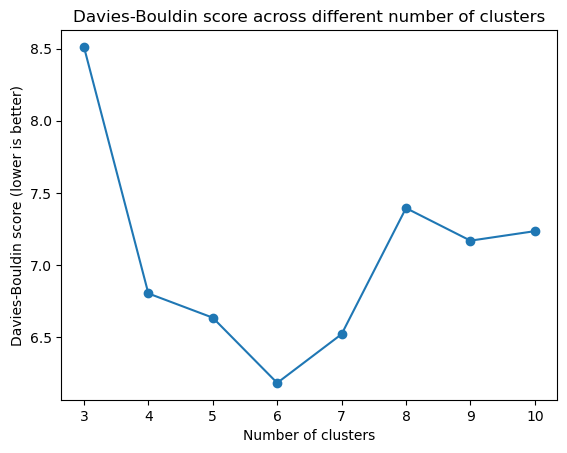

In [417]:
# Do K-means clustering
RANDOM_SEED = 42
n_clusters = range(3,11)

# Davies-Bouldin score, lower is better cluster separation
davies_bouldin_scores = []
kmeans_models: list[KMeans] = []
for k in n_clusters:
    kmeans = KMeans(init='k-means++', n_init='auto', n_clusters=k, random_state=RANDOM_SEED)
    kmeans.fit(tf_idf_vectors)
    kmeans_models.append(kmeans)
    davies_bouldin_scores.append(davies_bouldin_score(tf_idf_vectors.toarray(), kmeans.labels_))


# Plot the Davies-Bouldin score across different number of clusters
plt.plot(n_clusters, davies_bouldin_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin score (lower is better)')
plt.title('Davies-Bouldin score across different number of clusters')
plt.show()

In [418]:
best_idx = np.argmin(davies_bouldin_scores)
best_k = n_clusters[best_idx]
best_kmeans = kmeans_models[best_idx]

print('Baseline Clustering')
print(f'Best number of clusters: {best_k}')
print(f'Best Davies-Bouldin score (lower is better): {davies_bouldin_scores[best_idx]:.2f}')

Baseline Clustering
Best number of clusters: 6
Best Davies-Bouldin score (lower is better): 6.18


In [419]:
# Find the most frequent terms in each cluster
N_TOP_WORDS = 20
feature_names = tfidf_vectorizer.get_feature_names_out()
top_terms = []
for i in range(best_k):
    cluster_center = best_kmeans.cluster_centers_[i]
    top_term_indices = np.argsort(cluster_center)[-N_TOP_WORDS:][::-1]
    top_terms.append([feature_names[idx] for idx in top_term_indices])

print(f'Top {N_TOP_WORDS} terms in each cluster:')
for i, terms in enumerate(top_terms):
    print(f'Cluster {i+1}')
    print(', '.join(terms))
    print('-----------------------------------')

Top 20 terms in each cluster:
Cluster 1
compil, program, languag, code, graph, optim, memori, parallel, transform, implement, comput, processor, regist, theori, loop, design, system, type, applic, flow
-----------------------------------
Cluster 2
secur, encrypt, scheme, key, cryptographi, attack, iot, protocol, data, propos, authent, imag, cloud, algorithm, cryptograph, chaotic, system, implement, devic, base
-----------------------------------
Cluster 3
robot, control, soft, system, task, environ, learn, simul, human, model, actuat, perform, materi, optim, develop, soft robot, manipul, sensor, evolv, approach
-----------------------------------
Cluster 4
databas, data, queri, relat, relat databas, system, sql, ontolog, inform, model, schema, approach, manag, process, store, graph, inform system, user, web, semant
-----------------------------------
Cluster 5
imag, detect, vision, method, comput vision, model, learn, object, comput, deep, network, propos, system, video, track, featur,

## Improving clustering model
The following extra steps were done to improve the clustering result:
- Preprocessing:
  - detect synonyms by using WordNet (Future work)
- Clustering:
  - feature dimension reduction by using LSA
  - Use cosine similarity instead of L_2 distance -> data is already normalized so L_2 is OK!
  - Do Scatter/Gather
- Representation:
  - replace cluster centroids by cluster digests = most frequent words

In [420]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

from itertools import combinations
from collections import Counter

In [421]:
# Do LSA to reduce the feature dimension from 3828 to 100
# n_components = 80
# svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_SEED)
# reduced_tf_idf_vectors = svd.fit_transform(tf_idf_vectors)

The best number of components for LSA is 100


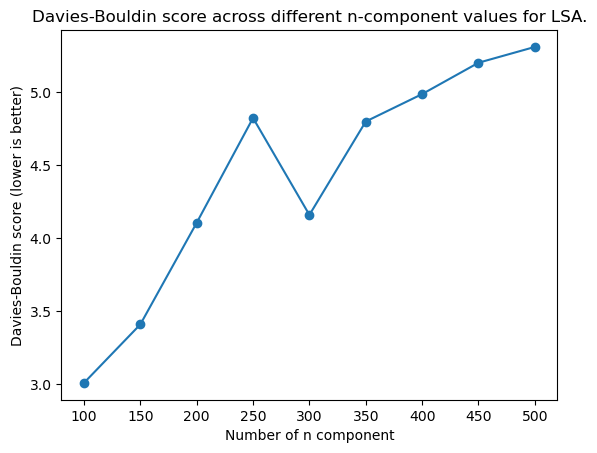

In [422]:
# LSA reduced version of the tf-idf vectors
n_components = list(range(100,501,50))

davies_bouldin_scores = []
lsa_kmeans_models: list[KMeans] = []
svds = {}
for i, n in enumerate(n_components):
    svd = TruncatedSVD(n_components=n, random_state=RANDOM_SEED)
    svd = svd.fit(tf_idf_vectors)
    svds[n] = svd

    reduced_tf_idf_vectors = svd.transform(tf_idf_vectors)

    db_scores_n = []
    kmeans_model_n = []
    for k in n_clusters:
        kmeans = KMeans(init='k-means++', n_init='auto', n_clusters=k, random_state=RANDOM_SEED)
        kmeans.fit(reduced_tf_idf_vectors)

        kmeans_model_n.append(kmeans)
        db_scores_n.append(davies_bouldin_score(reduced_tf_idf_vectors, kmeans.labels_))

    best_idx = np.argmin(db_scores_n)
    davies_bouldin_scores.append(db_scores_n[best_idx])
    lsa_kmeans_models.append(kmeans_model_n[best_idx])

best_idx = np.argmin(davies_bouldin_scores)
best_n_component = n_components[best_idx]
best_svd = svds[best_n_component]
best_lsa_kmean = lsa_kmeans_models[best_idx]
reduced_tf_idf_vectors = best_svd.transform(tf_idf_vectors)

print(f'The best number of components for LSA is {best_n_component}')

# Plot the Davies-Bouldin score across different number of clusters
plt.plot(n_components, davies_bouldin_scores, marker='o')
plt.xlabel('Number of n component')
plt.ylabel('Davies-Bouldin score (lower is better)')
plt.title('Davies-Bouldin score across different n-component values for LSA.')
plt.show()

In [423]:
print(f'The optimal number of clusters in LSA_Kmeans model: {len(np.unique(best_lsa_kmean.labels_))}')
print(f'DB score of that model: {davies_bouldin_scores[best_idx]}')

The optimal number of clusters in LSA_Kmeans model: 7
DB score of that model: 3.007404318907706


In [424]:
def buckshot_initialization(X: np.ndarray, n_clusters: int) -> np.ndarray:
    '''
    ### Scatter/Gather: Buckshot initialization
    '''
    # Select √(K*n) random samples
    num_samples = int(np.sqrt(n_clusters * X.shape[0]))
    random_indices = np.random.choice(X.shape[0], num_samples, replace=False)
    X_sample = X[random_indices]

    # Hierachical clustering on the sampled data
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    sample_labels = agg_clustering.fit_predict(X_sample)

    initial_seeds = []
    for cluster_id in range(n_clusters):
        cluster_points = X_sample[sample_labels == cluster_id]
        cluster_center = np.mean(cluster_points, axis=0)
        initial_seeds.append(cluster_center)
    
    return initial_seeds

def cluster_coherence(X: np.ndarray, labels: np.ndarray, cluster_id: int) -> float:
    cluster_points = X[labels == cluster_id]
    avg_sim = np.mean(cosine_similarity(cluster_points))
    return avg_sim

def get_fitted_kmeans(X: np.ndarray, n_clusters: int, initial_seeds: np.ndarray | str, random_state: int) -> KMeans:
    kmeans = KMeans(init=initial_seeds, n_init=1, n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(X)
    return kmeans

def split_incoherent_clusters(X: np.ndarray, labels: np.ndarray, threshold: float) -> np.ndarray:
    num_clusters = len(np.unique(labels))
    for cluster_id in range(num_clusters):
        coherence = cluster_coherence(X, labels, cluster_id)
        if coherence < threshold:
            # Split the cluster
            cluster_points = X[labels == cluster_id]
            buckshot_seeds = buckshot_initialization(cluster_points, 2)
            kmeans = get_fitted_kmeans(cluster_points, 2, buckshot_seeds, RANDOM_SEED)
            # Recluster the rest
            splitted_labels = kmeans.predict(cluster_points)
            
            # Update the labels
            for splitted_label in enumerate(splitted_labels):
                if splitted_label == 1:
                    labels[labels == cluster_id] = num_clusters
                    num_clusters += 1

    return labels

def merge_similar_clusters(X: np.ndarray, labels: np.ndarray, threshold: float) -> np.ndarray:
    cluster_centroids = [np.mean(X[labels == i], axis=0) for i in np.unique(labels)]

    for i, j in combinations(range(len(cluster_centroids)), 2):
        # Calculate the cosine similarity between two cluster centroids
        sim = cosine_similarity([cluster_centroids[i]], [cluster_centroids[j]])[0,0]
        if sim > threshold:
            labels[labels == j] = i

    return labels


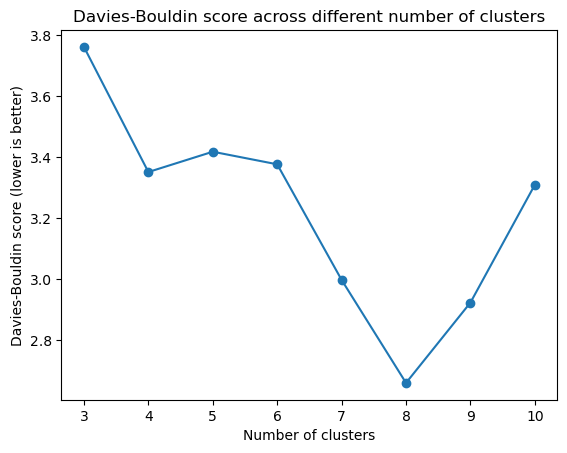

In [429]:
SPLIT_THRESHOLD = 0.2
MERGE_THRESHOLD = 0.8

davies_bouldin_scores = []
improved_kmeans_models: list[KMeans] = []
for k in n_clusters:
    buckshot_seeds = buckshot_initialization(reduced_tf_idf_vectors, k)
    kmeans = get_fitted_kmeans(reduced_tf_idf_vectors, k, buckshot_seeds, RANDOM_SEED)

    # kmeans = KMeans(init='k-means++', n_init='auto', n_clusters=k, random_state=RANDOM_SEED)
    # kmeans.fit(reduced_tf_idf_vectors)

    # Do Scatter/Gather refinement
    # refined_labels = kmeans.labels_
    # for cluster_id in range(k):
    #     refined_labels = split_incoherent_clusters(reduced_tf_idf_vectors, refined_labels, SPLIT_THRESHOLD)
    # refined_labels = merge_similar_clusters(reduced_tf_idf_vectors, refined_labels, MERGE_THRESHOLD)

    # kmeans.labels_ = refined_labels

    improved_kmeans_models.append(kmeans)
    davies_bouldin_scores.append(davies_bouldin_score(reduced_tf_idf_vectors, kmeans.labels_))

# Plot the Davies-Bouldin score across different number of clusters
plt.plot([len(np.unique(model.labels_)) for model in improved_kmeans_models], davies_bouldin_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin score (lower is better)')
plt.title('Davies-Bouldin score across different number of clusters')
plt.show()

In [430]:
best_idx = np.argmin(davies_bouldin_scores)
best_kmeans = improved_kmeans_models[best_idx]
best_k = len(np.unique(best_kmeans.labels_))

print('Improved Clustering')
print(f'Best number of clusters: {best_k}')
print(f'Best Davies-Bouldin score (lower is better): {davies_bouldin_scores[best_idx]:.2f}')

Improved Clustering
Best number of clusters: 8
Best Davies-Bouldin score (lower is better): 2.66


In [431]:
# Find the most frequent terms in each cluster
feature_names = tfidf_vectorizer.get_feature_names_out()
top_terms = []
original_space_cluster_centers = best_svd.inverse_transform(best_kmeans.cluster_centers_)

for i in range(best_k):
    cluster_center = best_kmeans.cluster_centers_[i]
    top_terms_indices = np.argsort(original_space_cluster_centers[i])[-N_TOP_WORDS:][::-1]
    top_terms.append([feature_names[idx] for idx in top_terms_indices])

print(f'Top {N_TOP_WORDS} terms in each cluster:')
for i, top_term in enumerate(top_terms):
    print(f'Cluster {i+1}')
    print(', '.join(top_term))
    print('-----------------------------------')



Top 20 terms in each cluster:
Cluster 1
robot, imag, detect, method, system, model, learn, vision, object, propos, comput, perform, comput vision, network, control, track, deep, estim, result, train
-----------------------------------
Cluster 2
quantum, quantum comput, secur, comput, compil, gate, key, cryptographi, protocol, circuit, qubit, attack, post quantum, algorithm, oper, state, communic, post, classic, program
-----------------------------------
Cluster 3
compil, program, languag, code, graph, memori, parallel, transform, optim, implement, processor, regist, comput, theori, design, applic, loop, flow, level, system
-----------------------------------
Cluster 4
queri, sql, databas, languag, relat, sql queri, data, relat databas, natur languag, translat, user, execut, natur, approach, fuzzi, graph, model, system, queri execut, process
-----------------------------------
Cluster 5
secur, encrypt, scheme, key, cryptographi, protocol, attack, iot, propos, data, authent, imag, cloud

In [432]:
# Modifications of K-representatives: Replace cluster centroids by cluster digests
cluster_digests = {}
for cluster_id in range(best_k):
    cluster_docs = np.where(best_kmeans.labels_ == cluster_id)[0]
    combined_terms = [term for doc_index in cluster_docs for term in tokens_list[doc_index]]
    term_freqs = Counter(combined_terms)
    cluster_digests[cluster_id] = [term for term, _ in term_freqs.most_common(N_TOP_WORDS)]


for cluster_id, terms in cluster_digests.items():
    print(f"Cluster {cluster_id+1} digest:")
    print(", ".join(terms))
    print('-----------------------------------')

Cluster 1 digest:
robot, method, imag, system, model, propos, detect, perform, learn, comput, result, base, data, algorithm, vision, network, approach, object, studi, develop
-----------------------------------
Cluster 2 digest:
quantum, comput, secur, compil, algorithm, cryptographi, oper, propos, key, implement, protocol, attack, gate, program, state, circuit, scheme, communic, post-quantum, time
-----------------------------------
Cluster 3 digest:
compil, program, code, languag, comput, optim, system, graph, implement, memori, paper, parallel, design, applic, perform, transform, algorithm, approach, model, base
-----------------------------------
Cluster 4 digest:
queri, databas, data, sql, relat, languag, system, approach, model, process, execut, user, translat, propos, natur, base, specul, paper, result, algorithm
-----------------------------------
Cluster 5 digest:
secur, encrypt, propos, data, scheme, key, cryptographi, system, base, algorithm, imag, attack, protocol, comput, 